In [51]:
from matplotlib import pyplot as plt

from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from pathlib import Path
import regex

from collections import defaultdict
from tqdm import tqdm

In [55]:
questions = [
    "What is the largest cavity diameter of MIBQAR16?",  # 1 step
    "How does the density of LITDAV compare to other materials",  # 2 step
    "Find the MOF with the highest hydrogen diffusivity at 77K, 1bar.",  # 3 step
    "What is the relationship between H2 uptake and accessible volume in MOFs?",  # 4 step
    "Provide the CO2 henry coefficient of XEGKUR at 298 K in mol/cm3Pa",  # 8 step
]

In [56]:
answers = [
    'The largest cavity diameter of MIBQAR16 is 15.0001 Å',
    'The density of LITDAV is 1.01002 g/cm^3, which is lower than the average density of other materials, which is 1.373 g/cm^3.',
    "The MOF with the highest hydrogen diffusivity at 77K, 1bar is 'BAZGAM_clean' with a value of 0.0030176841738998412 cm^2/s",
    'The correlation between H2 uptake and accessible volume in MOFs is approximately 0.6, indicating a moderate positive relationship.',
    "The CO2 Henry's coefficient of XEGKUR at 298 K is 2.75e-05 mol/cm3Pa.",
]

In [57]:
keypoints = [
    "How efficiently can you write code to get a property?",
    "How efficiently can you write code to get a property? How efficiently can you perform a 'compare to other material'?",
    "How efficiently can you write code to get a property? The hydrogen diffusivity model is logarithmic, so you have to check  exponentialize it to get the original value.",
    "How efficiently can you write code to get a property? How do I get the relationship?",
    "How efficiently can you write code to get a property? Does it do the unit conversion correctly? Does it do a good job of finding the density needed for the unit conversion?",
]

In [58]:
prompt = """You are the evaluator of the chatbot. 
You have to rate the process of chatbot on a scale of 0-100 on how well it planned to solve the question and how well it executed.

Question : {question}

True Answer: {answer}

Key Point : {keypoint}

Chatbot Process : {process}

Score :"""

In [ ]:
llm = ChatOpenAI(model='gpt-4', temperature=0)
template = PromptTemplate(template=prompt, input_variables=['question', 'answer', 'keypoint', 'process'])
chain = LLMChain(llm=llm, prompt=template)

In [62]:
outputs = list(Path('./test/revision_temperature/').glob('*.output'))

In [66]:
save_dict = {
    'gpt-4': defaultdict(lambda : defaultdict(list)),
    'gpt-3.5-turbo': defaultdict(lambda: defaultdict(list))
}

In [182]:
for file in tqdm(outputs):
    qnum, time, temperature, model = file.stem.split('_')
    qnum = int(qnum[1:])
    question = questions[qnum]
    answer = answers[qnum]
    keypoint = keypoints[qnum]
    temperature = float(temperature)
    time = int(time)

    with open(file) as f:
        data = f.read().strip()

    data = regex.sub(r"\|.+?\|\n", "", data)
    data = regex.sub(r"Predicting DataLoader .+?\n", "", data)
    try:
        evaluation = chain.run(
            question=question,
            process = data,
            keypoint=keypoint,
            answer=answer
        )
    except Exception as e:
        print (file.stem)
        continue

    save_dict[model][qnum][temperature].append(evaluation)

In [69]:
import copy
import numpy as np

In [126]:
plt.rcParams['font.family'] = 'arial'

import seaborn as sns 
sns.set_palette('colorblind')

(37.25, 100.0)

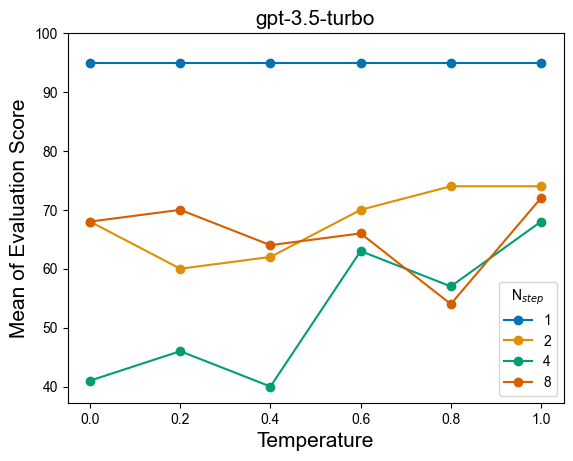

In [187]:
model = 'gpt-3.5-turbo'
#model = 'gpt-4'

labels = []

for q in [0, 1,  3, 4]:
    dict1 = save_dict[model][q]
    tmp_dict = dict()
    std_dict = dict()
    for temp in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    #for temp, data in dict1.items():
        data = dict1[temp]
        data = [float(regex.match(r"^\d+", d).group(0)) for d in data]
        tmp_dict[temp] = np.mean(data)
        std_dict[temp] = np.std(data)

    labels.append(q)
    plt.plot(tmp_dict.keys(), tmp_dict.values(), 'o-')

plt.legend([1, 2, 4, 8], title='N$_{step}$')
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Mean of Evaluation Score', fontsize=15)
plt.title(model, fontsize=15)
plt.ylim(None, 100)

Text(0.5, 1.0, 'gpt-3.5-turbo')

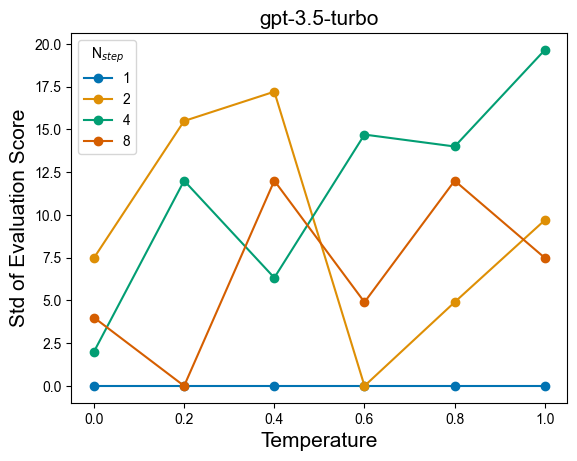

In [188]:
model = 'gpt-3.5-turbo'

labels = []

for q in [0, 1, 3, 4]:
    dict1 = save_dict[model][q]
    tmp_dict = dict()
    std_dict = dict()
    for temp in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    #for temp, data in dict1.items():
        data = dict1[temp]
        data = [float(regex.match(r"^\d+", d).group(0)) for d in data]
        tmp_dict[temp] = np.mean(data)
        std_dict[temp] = np.std(data)

    labels.append(q)
    plt.plot(std_dict.keys(), std_dict.values(), 'o-')

plt.legend([1, 2, 4, 8], title='N$_{step}$')
plt.xlabel('Temperature', fontsize=15)
plt.ylabel('Std of Evaluation Score', fontsize=15)
plt.title(model, fontsize=15)
#plt.ylim(None, 100)

In [185]:
save_dict['gpt-4'][4]

defaultdict(list,
            {1.0: ['70/100', '95', '95', '70/100', '90/100'],
             0.0: ['95', '95', '95', '90/100', '90/100'],
             0.6: ['90/100', '90/100', '85', '70', '80/100'],
             0.8: ['70/100', '90/100', '80/100', '95', '90/100'],
             0.2: ['95', '70/100', '95', '85', '90'],
             0.4: ['85', '90/100', '70/100', '85', '80/100']})

In [166]:
save_dict['gpt-4'][3]

defaultdict(list,
            {0.4: ['80/100', '85', '85', '85', '60'],
             1.0: ['85', '90/100', '85', '85', '60'],
             0.6: ['85', '85', '60', '60', '90/100'],
             0.2: ['85', '85', '90/100', '85', '95'],
             0.0: ['90/100', '85', '90/100', '85', '90/100'],
             0.8: ['85/100', '60/100', '85', '90/100', '85/100']})